# Taylor tests

It is good practice to check the derivatives formula with Taylor tests. For a given $C^1$ function, the first order Taylor expansion reads 

$$ f(x+h) = f(x) + df(x) h + O(h^2) $$

So the Taylor remainder $ \mathcal R(x,h) = f(x+h) - f(x) - df(x) h $ should decrease quadratically with $h$.

In [1]:
from shapeOptInductor import gen_mesh2, Id
import ngsolve as ngs
from ngsolve.webgui import Draw
import numpy as np
import matplotlib.pyplot as plt


## 1 - Geometry and meshing

We test our expression of shape gradient on the four control points.

In [2]:
airgap = 4.11e-3 * np.array([1, 1, 1, 1])
lz = 1e-2
s = 4
maxh = 2e-3
mesh = gen_mesh2(airgap, maxh)

XiAir = mesh.MaterialCF({"air": 1})
XiCore = mesh.MaterialCF({"core": 1})
XiCoil = mesh.MaterialCF({"coil": 1})

Draw(1 * XiAir + 2 * XiCoil + 3 * XiCore, mesh, radius=0.02)


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

## 2 - State problem

### a) Parameters definition

In [3]:
f = 5e4  # working frequency (Hz)
omega = 2 * np.pi * f  # rad/s
mu0 = 4e-7 * np.pi  # void permeability (H/m)
mur = 1000  # relative permeability of iron (no unit)
mu_iron = mur * mu0  # permeability of iron (H/m)
delta = 0.1  # loss angle associated with the coil (rad)
mu_coil = np.exp(-1j * delta) * mu0  # complex permeability
nb_turn = 200  # number of turn in the coil (no unit)
Is = 2  # source current intensity (A)
js = nb_turn / 2 * Is / (ngs.Integrate(XiCoil, mesh)) * XiCoil  # source current density (A/m²)


### b) Definition of the magnetic problem

In [4]:
def magWeakFormComplex(a, a_):
    """Return the complex weak form of the magnetic problem, i.e, bilinear
    and linear forms (matrix and right-hand side after discretization, respectively)"""

    # bilinear form (transmission)
    bf = ngs.grad(a_) * 1 / mu_iron * ngs.grad(a) * ngs.dx("core")
    bf += ngs.grad(a_) * 1 / mu_coil * ngs.grad(a) * ngs.dx("coil")
    bf += ngs.grad(a_) * 1 / mu0 * ngs.grad(a) * ngs.dx("air")

    # linear form (source)
    lf = a_ * js * ngs.dx("coil")

    return bf, lf


def solveStateComplex(mesh):
    """Solve the complex magnetic state"""
    # definition of function space
    fes = ngs.H1(mesh, order=1, dirichlet="arc|segment2|domainVert", complex=True)
    a, a_ = fes.TnT()

    # definition of weak form
    bf, f = magWeakFormComplex(a, a_)
    K, F = ngs.BilinearForm(fes), ngs.LinearForm(fes)
    K += bf
    F += f

    # assembly
    K.Assemble()
    F.Assemble()

    # solving
    gf = ngs.GridFunction(fes)
    Kinv = K.mat.Inverse(freedofs=fes.FreeDofs(), inverse="pardiso")
    gf.vec.data = Kinv * F.vec

    return gf, Kinv  # returning Kinv speed up adjoint calculation


### c) Definition of the post-processed quantities

We define the losses and inductance, with the directional derivative of their local quantities.

In [5]:
def Inductance(a, mesh):
    rel = XiAir / mu0 + XiCoil / mu_coil + XiCore / mu_iron
    return s * lz / (Is**2) * ngs.Integrate(rel.real * ngs.Norm(ngs.grad(a)) ** 2, mesh)


def dInductance(a, p_, mesh):
    rel = XiAir / mu0 + XiCoil / mu_coil + XiCore / mu_iron
    return 2 * s * lz / (Is**2) * ngs.InnerProduct(rel.real * ngs.grad(a), ngs.grad(p_)) * ngs.dx()


def Losses(a, mesh):
    rel = XiCoil / mu_coil
    return s * np.pi * f * lz * ngs.Integrate(rel.imag * ngs.Norm(ngs.grad(a)) ** 2, mesh)


def dLosses(a, p_, mesh):
    rel = XiCoil / mu_coil
    return 2 * s * np.pi * f * lz * ngs.InnerProduct(rel.imag * ngs.grad(a), ngs.grad(p_)) * ngs.dx()


## 3 - Adjoint problem

The adjoint method is an efficient way to compute derivatives of PDE-constrained problems. We look for the adjoint $p_f \in H^1(\Omega, \mathbb C), p_f = 0$ on the vertical symmetry axis and outer boundary, and solving for any $p^* \in H_1(\Omega, \mathbb R)$

$$ \int_\Omega \nabla \underline{p} \cdot \left( \frac{\chi_c}{\underline{\mu_f}} + \frac{\chi_f}{\underline{\mu_f}} +\frac{\chi_a}{\underline{\mu_0}}\right)^* \nabla p^* = f'(\underline{a})(p^*), $$

with $f'$ the directional derivative of $f$, such that $F(\underline{a}) = \int_\Omega f(\underline{a}) \; \mathrm{d}x$ 

In [6]:
def solveAdjoint(a0, df, Kinv):
    """Solve the adjoint equation for a given df"""
    fes = a0.space
    p, p_ = fes.TnT()
    f = ngs.LinearForm(fes)
    f += -1 * df(a0, p_, fes.mesh)
    f.Assemble()
    gf = ngs.GridFunction(fes)
    gf.vec.data = Kinv.H * f.vec
    return gf


## 4 - Shape derivative

Detailed computation will be given soon... the state and adjoint version are needed.

In [7]:
def SDLosses(a0, p0):
    """Shape derivative for the losses inside the coil"""
    mesh = a0.space.mesh
    FESReal = ngs.VectorH1(mesh)
    FEScomplex = ngs.VectorH1(mesh, complex=True)
    X = FEScomplex.TestFunction()

    rel = (1 / mu0) * XiAir + (1 / mu_coil) * XiCoil + (1 / mu_iron) * XiCore
    coeff_losses = s * np.pi * f * lz * (1 / mu_coil).imag
    dA = ngs.div(X) * Id - ngs.grad(X) - ngs.grad(X).trans

    dLOmega = ngs.LinearForm(FEScomplex)
    dLOmega += coeff_losses * ngs.InnerProduct(dA * ngs.grad(a0), ngs.grad(a0)) * ngs.dx("coil")
    dLOmega += -js * XiCoil * ngs.div(X) * p0 * ngs.dx
    dLOmega += ngs.InnerProduct(rel * dA * ngs.grad(a0), ngs.grad(p0)) * ngs.dx
    dLOmega.Assemble()

    dJ = ngs.GridFunction(FESReal)
    dJ.vec.FV().NumPy()[:] = np.real(dLOmega.vec.FV().NumPy()[:])
    return dJ


def SDInductance(a0, p0):
    """Shape derivative for the inductance"""
    mesh = a0.space.mesh
    FESReal = ngs.VectorH1(mesh)
    FEScomplex = ngs.VectorH1(mesh, complex=True)
    X = FEScomplex.TestFunction()

    rel = (1 / mu0) * XiAir + (1 / mu_coil) * XiCoil + (1 / mu_iron) * XiCore
    Id = ngs.CoefficientFunction((1, 0, 0, 1), dims=(2, 2))  # Identity matrix
    coeff_induc = s * lz / (Is**2) * rel.real
    dA = ngs.div(X) * Id - ngs.grad(X) - ngs.grad(X).trans

    dLOmega = ngs.LinearForm(FEScomplex)
    dLOmega += coeff_induc * ngs.InnerProduct(dA * ngs.grad(a0), ngs.grad(a0)) * ngs.dx
    dLOmega += -js * ngs.div(X) * p0 * ngs.dx
    dLOmega += ngs.InnerProduct(rel * dA * ngs.grad(a0), ngs.grad(p0)) * ngs.dx
    dLOmega.Assemble()

    dJ = ngs.GridFunction(FESReal)
    dJ.vec.FV().NumPy()[:] = np.real(dLOmega.vec.FV().NumPy()[:])
    return dJ


## 5 - Gradient

Parametric gradient can be obtained by taking the scalar product of the shape derivative with a velocity field induced by the displacement of the control points.

In [8]:
from shapeOptInductor import referenceVelocity


def shapeGrad(a0, p0, dJ):
    v11, v12, v21, v22 = referenceVelocity(a0.space.mesh)
    dJlf = dJ(a0, p0)
    FES = ngs.VectorH1(a0.space.mesh)
    dJ = ngs.GridFunction(FES)
    dJ.vec.FV().NumPy()[:] = np.real(dJlf.vec.FV().NumPy()[:])
    g11 = ngs.InnerProduct(dJ.vec, v11.vec)
    g12 = ngs.InnerProduct(dJ.vec, v12.vec)
    g21 = ngs.InnerProduct(dJ.vec, v21.vec)
    g22 = ngs.InnerProduct(dJ.vec, v22.vec)
    return g11, g12, g21, g22


## 6 - Taylor tests

The expressions are correct if the decrease of Taylor remainder is quadratic.

In [9]:
nTest = 0  # 0 : inductance, 1 : losses


In [10]:
H = np.logspace(-8, -3, 10)

# unperturbed computation
airgap = 4.11e-3 * np.array([1, 1, 1, 1])
mesh = gen_mesh2(airgap, maxh)
a0, Kinv = solveStateComplex(mesh)

if nTest == 0:
    f, df, SDf = Inductance, dInductance, SDInductance
elif nTest == 1:
    f, df, SDf = Losses, dLosses, SDLosses

F0 = f(a0, mesh)
p0 = solveAdjoint(a0, df, Kinv)
dF = shapeGrad(a0, p0, SDf)
H = np.logspace(-8, -2, 10)

# perturbed computations
v11, v12, v21, v22 = referenceVelocity(mesh)
Fh11, Fh12, Fh21, Fh22 = [], [], [], []
Def = ngs.GridFunction(ngs.VectorH1(mesh))

for h in H:
    ## g11
    Def.Set(v11 * h)
    mesh.SetDeformation(Def)
    a, _ = solveStateComplex(mesh)
    Fh11.append(f(a, mesh))
    ## g12
    Def.Set(v12 * h)
    mesh.SetDeformation(Def)
    a, _ = solveStateComplex(mesh)
    Fh12.append(f(a, mesh))
    ## g21
    Def.Set(v21 * h)
    mesh.SetDeformation(Def)
    a, _ = solveStateComplex(mesh)
    Fh21.append(f(a, mesh))
    ## g22
    Def.Set(v22 * h)
    mesh.SetDeformation(Def)
    a, _ = solveStateComplex(mesh)
    Fh22.append(f(a, mesh))
mesh.UnsetDeformation()


In [11]:
# Computation of Taylor remainder

TR11 = np.array(Fh11) - F0 - dF[0] * H
TR12 = np.array(Fh12) - F0 - dF[1] * H
TR21 = np.array(Fh21) - F0 - dF[2] * H
TR22 = np.array(Fh22) - F0 - dF[3] * H


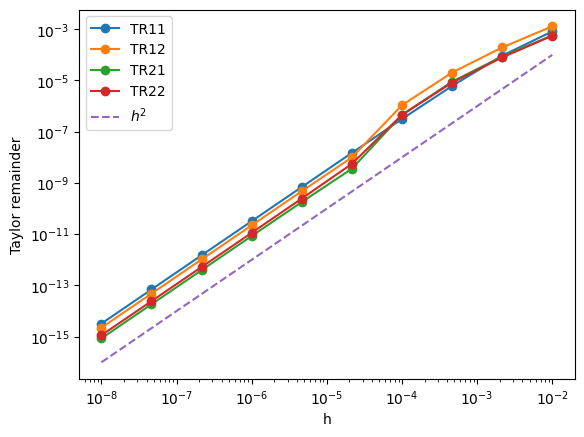

In [12]:
# Display

plt.loglog(H, TR11, "-o", label="TR11")
plt.xlabel("h")
plt.loglog(H, TR12, "-o", label="TR12")
plt.loglog(H, TR21, "-o", label="TR21")
plt.ylabel("Taylor remainder")
plt.loglog(H, TR22, "-o", label="TR22")
plt.loglog(H, H**2, "--", label="$h^2$")
plt.legend()
plt.show()
